In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import networkx as nx
import re
import pickle
from itertools import combinations

In [133]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

In [2]:
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.datasets import fetch_openml, make_classification
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance

In [3]:
from ucimlrepo import fetch_ucirepo, list_available_datasets
from pmlb import fetch_data, classification_dataset_names

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
%run graph_building.py
%run parsing_rules.py

# SYNTHETIC DATASETS

### GENERATE SYNTHETIC DATASETS WITH INDEPENDENTLY PREDICTIVE FEATURES

In [ ]:
all_intervals = {
    2: [
    [(0.2, 0.4), (0.7, 0.9)],  # Intervals for X1
    [(0.3, 0.5), (0.8, 1.0)]   # Intervals for X2
        ],
    3:  [
    [(0.2, 0.4), (0.7, 0.9)],  # Intervals for X1
    [(0.1, 0.3), (0.6, 0.8)],  # Intervals for X2
    [(0.3, 0.5), (0.8, 1.0)]   # Intervals for X3
        ],
    4:  [
    [(0.2, 0.35), (0.7, 0.85)],  # Intervals for X1
    [(0.1, 0.25), (0.6, 0.75)],  # Intervals for X2
    [(0.3, 0.45), (0.8, 0.95)],  # Intervals for X3
    [(0.0, 0.15), (0.5, 0.65)]   # Intervals for X4
        ],
    5:  [
    [(0.2, 0.3), (0.7, 0.8)],  # Intervals for X1
    [(0.1, 0.2), (0.6, 0.7)],  # Intervals for X2
    [(0.3, 0.4), (0.8, 0.9)],  # Intervals for X3
    [(0.0, 0.1), (0.5, 0.6)],  # Intervals for X4
    [(0.4, 0.5), (0.9, 1.0)]   # Intervals for X5
        ],
    6:  [
    [(0.2, 0.25), (0.75, 0.8)],  # Intervals for X1
    [(0.1, 0.15), (0.65, 0.7)],  # Intervals for X2
    [(0.3, 0.35), (0.85, 0.9)],  # Intervals for X3
    [(0.0, 0.05), (0.55, 0.6)],  # Intervals for X4
    [(0.4, 0.45), (0.95, 1.0)],  # Intervals for X5
    [(0.5, 0.55), (0.9, 0.95)]   # Intervals for X6
    ]
}

# independent
n_samples = 2000
seeds = 10
for n_relevant_features in [2,3,4,5,6]:
    for seed in range(seeds):
        random.seed(seed)
        np.random.seed(seed)
        n_irrelevant_features = 8 - n_relevant_features
        # Generate the relevant features
        X_relevant = [np.random.rand(n_samples) for _ in range(n_relevant_features)]
        
        # Generate the irrelevant features
        X_irrelevant = [np.random.rand(n_samples) for _ in range(n_irrelevant_features)]
        
        # Generate the target variable
        intervals = all_intervals[n_relevant_features]
        y = np.zeros(n_samples)
        for i, feature in enumerate(X_relevant):
            for interval in intervals[i]:
                y += (feature >= interval[0]) & (feature <= interval[1])
        y = (y > 0).astype(int)  # Convert to binary
        
        # Combine into a DataFrame
        data = { f'X{i+1}': X_relevant[i] for i in range(n_relevant_features) }
        data.update({ f'X{n_relevant_features+i+1}': X_irrelevant[i] for i in range(n_irrelevant_features) })
        data['target'] = y
        df = pd.DataFrame(data)
        df.to_csv(f"ind_synthetic_{n_relevant_features}_{seed}.csv")

### GENERATE SYNTHETIC DATASETS WITH COMBINED PREDICTIVE FEATURES

In [ ]:
# complementary
n_samples = 2000
for n_relevant_features in [2,3,4,5,6]:
    for seed in range(seeds):
        random.seed(seed)
        np.random.seed(seed)
        
        n_irrelevant_features = 8 - n_relevant_features
        
        # Generate the relevant features
        X_relevant = [np.random.rand(n_samples) for _ in range(n_relevant_features)]
        
        # Generate the irrelevant features
        X_irrelevant = [np.random.rand(n_samples) for _ in range(n_irrelevant_features)]
        
        # Combine into a DataFrame
        data = { f'X{i+1}': X_relevant[i] for i in range(n_relevant_features) }
        data.update({ f'X{n_relevant_features+i+1}': X_irrelevant[i] for i in range(n_irrelevant_features) })
        # Create DataFrame
        df = pd.DataFrame(data)

        target = np.zeros(n_samples, dtype=int)
        for feature in X_relevant:
            target += (feature > 0.5).astype(int)
        target = (target > 0.5*n_relevant_features).astype(int)
        
        df['target'] = target

        df.to_csv(f"comp_synthetic_{n_relevant_features}_{seed}.csv")

### TRAIN DECISION TREES on SYNTHETIC DATASETS 

In [ ]:
# save results
all_ind_adj = {}
all_comp_adj = {}
all_adj = [all_ind_adj, all_comp_adj]
all_ind_imp = {}
all_comp_imp = {}
all_imp = [all_ind_imp, all_comp_imp]

# parameters
seeds = 10
nfolds = 5
outer_cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_grid = {
            'max_depth': np.linspace(4,30,13).astype(int),
            'min_samples_leaf': [2, 4],
             }

cond_type = "relevance"
rule_type = "relevance"
feat_names = ["1", "2", "3", "4", "5", "6", "7", "8"]

for n_relevant_features in [2,3,4,5,6]:
    print("features", n_relevant_features)
    for tt, type in enumerate(["ind", "comp"]):
        adj_all = np.zeros((len(feat_names), len(feat_names)))
        imp_all = np.zeros((len(feat_names), folds, seeds))     
        print(type)
        for seed in range(seeds):
            print("seed ",seed)
            df = pd.read_csv(f"{type}_synthetic_{n_relevant_features}_{seed}.csv", index_col = 0) 
            feat_names = df.columns[:-1]
            X = df.iloc[:,:-1].values
            y = df.iloc[:,-1].values
            for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                train, test = df.iloc[train_idx], df.iloc[test_idx]
            
                predictor = GridSearchCV( estimator=DecisionTreeClassifier(random_state=100), 
                    param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
                best_params = predictor.best_params_
                best_model = predictor.best_estimator_
                print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
            
                parsed_rules = traverse_tree(best_model, feat_names, best_model.classes_)
                rules_text = export_text(best_model, feature_names=feat_names)
                rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
            
                adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
                imp_all[:,rr,seed] = best_model.feature_importances_
            
        all_adj[tt][n_relevant_features] = adj_all/(seeds*folds)
        all_imp[tt][n_relevant_features] = imp_all

save pickle
with open('all_adj_synthetic.pickle', 'wb') as handle:
   pickle.dump(all_adj, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_imp_synthetic.pickle', 'wb') as handle:
   pickle.dump(all_imp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
# Load the data from pickle files
with open('all_adj_synthetic.pickle', 'rb') as handle:
    all_adj = pickle.load(handle)

with open('all_imp_synthetic.pickle', 'rb') as handle:
    all_imp = pickle.load(handle)

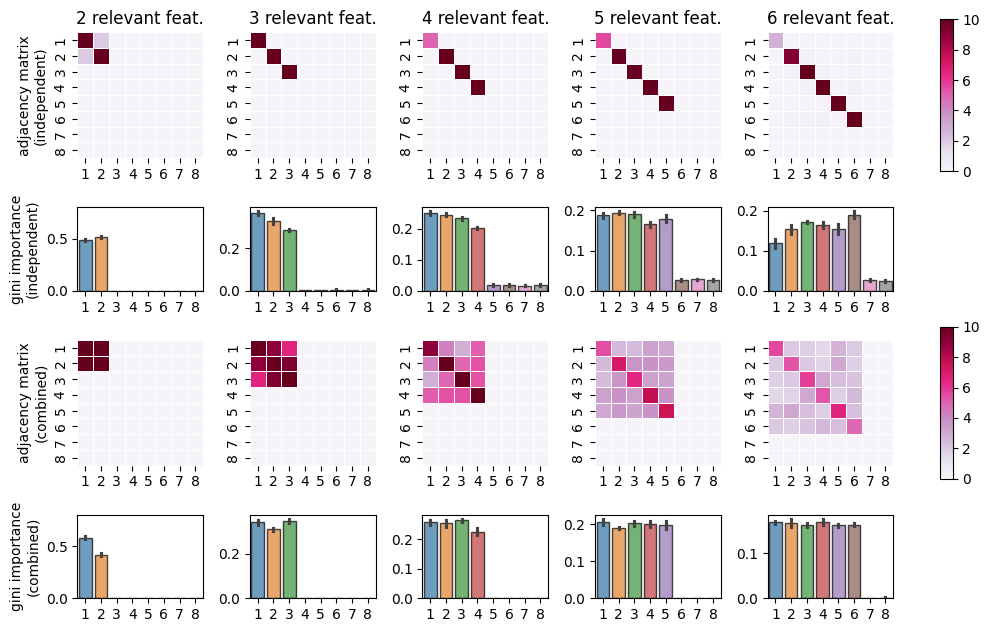

In [135]:
cmap = mpl.cm.BuPu(np.linspace(0,1,30))
cmap = ListedColormap(cmap[4:,:-1])

fig, axes = plt.subplots(4, 6, height_ratios=[2, 1.1, 2, 1.1], figsize=(10, 6.5), width_ratios=[1, 1, 1, 1, 1, 0.1])
feat_names = ["1", "2", "3", "4", "5", "6", "7", "8"]
cmap = "PuRd"
heatmap = sns.heatmap(all_adj[0][2], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][0], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj[0][3], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][1], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj[0][4], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][2], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)
sns.heatmap(all_adj[0][5], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][3], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)
sns.heatmap(all_adj[0][6], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][4], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)

sns.barplot(pd.DataFrame(all_imp[0][2].mean(axis = 2).T, columns = feat_names), ax = axes[1][0], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[0][3].mean(axis = 2).T, columns = feat_names), ax = axes[1][1], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[0][4].mean(axis = 2).T, columns = feat_names), ax = axes[1][2], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[0][5].mean(axis = 2).T, columns = feat_names), ax = axes[1][3], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[0][6].mean(axis = 2).T, columns = feat_names), ax = axes[1][4], edgecolor="k", alpha = 0.7)

sns.heatmap(all_adj[1][2], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[2][0], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj[1][3], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[2][1], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj[1][4], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[2][2], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)
sns.heatmap(all_adj[1][5], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[2][3], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)
sns.heatmap(all_adj[1][6], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[2][4], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names)

sns.barplot(pd.DataFrame(all_imp[1][2].mean(axis = 2).T, columns = feat_names), ax = axes[3][0], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[1][3].mean(axis = 2).T, columns = feat_names), ax = axes[3][1], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[1][4].mean(axis = 2).T, columns = feat_names), ax = axes[3][2], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[1][5].mean(axis = 2).T, columns = feat_names), ax = axes[3][3], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp[1][6].mean(axis = 2).T, columns = feat_names), ax = axes[3][4], edgecolor="k", alpha = 0.7)

fig.colorbar(heatmap.collections[0], cax=axes[0][5])
fig.colorbar(heatmap.collections[0], cax=axes[2][5])
axes[1][5].axis('off')
axes[3][5].axis('off')

axes[0][0].set_title("2 relevant feat.")
axes[0][1].set_title("3 relevant feat.")
axes[0][2].set_title("4 relevant feat.")
axes[0][3].set_title("5 relevant feat.")
axes[0][4].set_title("6 relevant feat.")

axes[1][0].set_ylim([0,0.8])
axes[3][0].set_ylim([0,0.8])

axes[0][0].set_ylabel("adjacency matrix\n(independent)", fontsize = 10)
axes[1][0].set_ylabel("gini importance\n(independent)", fontsize = 10)
axes[2][0].set_ylabel("adjacency matrix\n(combined)", fontsize = 10)
axes[3][0].set_ylabel("gini importance\n(combined)", fontsize = 10)

fig.tight_layout()
plt.show()
#plt.savefig("synthetic1.pdf")
#plt.savefig("synthetic1.png", dpi = 300)

### GENERATE SYNTHETIC DATASETS WITH MIXED FEATURES

In [ ]:
n_samples = 2000
seeds = 10
n_relevant_features = 4

for seed in range(seeds):
    random.seed(seed)
    np.random.seed(seed)
    n_irrelevant_features = 8 - n_relevant_features
    
    # Generate the relevant features
    X_relevant = [np.random.rand(n_samples) for _ in range(n_relevant_features)]
    # Generate the irrelevant features
    X_irrelevant = [np.random.rand(n_samples) for _ in range(n_irrelevant_features)]
    # Generate the target variable
    y = np.zeros(n_samples)

    # get independent target
    intervals = all_intervals[2]
    y += (X_relevant[0] >= intervals[0][0][0]) & (X_relevant[0] <= intervals[0][0][1])
    y += (X_relevant[0] >= intervals[0][1][0]) & (X_relevant[0] <= intervals[0][1][1])
    y += (X_relevant[1] >= intervals[1][0][0]) & (X_relevant[1] <= intervals[1][0][1])
    y += (X_relevant[1] >= intervals[1][1][0]) & (X_relevant[1] <= intervals[1][1][1])
    # complementary target
    y += (((X_relevant[2] > 0.5).astype(int) + (X_relevant[3] > 0.5).astype(int)) > 1).astype(int)
    y = (y > 0).astype(int)  # Convert to binary
    
    # Combine into a DataFrame
    data = { f'X{i+1}': X_relevant[i] for i in range(n_relevant_features) }
    data.update({ f'X{n_relevant_features+i+1}': X_irrelevant[i] for i in range(n_irrelevant_features) })
    data['target'] = y
    df = pd.DataFrame(data)
    df.to_csv(f"comb_1-2-34_synthetic_{seed}.csv")

for seed in range(seeds):
    random.seed(seed)
    np.random.seed(seed)
    n_irrelevant_features = 8 - n_relevant_features
    
    # Generate the relevant features
    X_relevant = [np.random.rand(n_samples) for _ in range(n_relevant_features)]
    # Generate the irrelevant features
    X_irrelevant = [np.random.rand(n_samples) for _ in range(n_irrelevant_features)]
    # Generate the target variable
    y = np.zeros(n_samples)

    # get independent target
    intervals = all_intervals[2]
    y += (X_relevant[0] >= intervals[0][0][0]) & (X_relevant[0] <= intervals[0][0][1])
    y += (X_relevant[0] >= intervals[0][1][0]) & (X_relevant[0] <= intervals[0][1][1])
    # complementary target
    y += (((X_relevant[1] > 0.5).astype(int) + (X_relevant[2] > 0.5).astype(int) + (X_relevant[3] > 0.5).astype(int)) > 1).astype(int)
    y = (y > 0).astype(int)  # Convert to binary
    
    # Combine into a DataFrame
    data = { f'X{i+1}': X_relevant[i] for i in range(n_relevant_features) }
    data.update({ f'X{n_relevant_features+i+1}': X_irrelevant[i] for i in range(n_irrelevant_features) })
    data['target'] = y
    df = pd.DataFrame(data)
    df.to_csv(f"comb_1-234_synthetic_{seed}.csv")

for seed in range(seeds):
    random.seed(seed)
    np.random.seed(seed)
    n_irrelevant_features = 8 - n_relevant_features
    
    # Generate the relevant features
    X_relevant = [np.random.rand(n_samples) for _ in range(n_relevant_features)]
    # Generate the irrelevant features
    X_irrelevant = [np.random.rand(n_samples) for _ in range(n_irrelevant_features)]
    
    # Generate the target variable
    intervals = all_intervals[n_relevant_features]
    y = np.zeros(n_samples)
    # get independent target
    y += (((X_relevant[0] > 0.5).astype(int) + (X_relevant[1] > 0.5).astype(int)) > 1).astype(int)
    # complementary target
    y += (((X_relevant[2] > 0.5).astype(int) + (X_relevant[3] > 0.5).astype(int)) > 1).astype(int)
    y = (y > 0).astype(int)  # Convert to binary
    
    # Combine into a DataFrame
    data = { f'X{i+1}': X_relevant[i] for i in range(n_relevant_features) }
    data.update({ f'X{n_relevant_features+i+1}': X_irrelevant[i] for i in range(n_irrelevant_features) })
    data['target'] = y
    df = pd.DataFrame(data)
    df.to_csv(f"comb_12-34_synthetic_{seed}.csv")

### TRAIN DECISION TREES on SYNTHETIC DATASETS 

In [ ]:
all_adj2 = {}
all_imp2 = {}

for tt, type in enumerate(["1-2-34", "1-234", "12-34"]):
    adj_all = np.zeros((len(feat_names), len(feat_names)))
    imp_all = np.zeros((len(feat_names), folds, seeds))     
    print(type)
    for seed in range(seeds):
        print("seed ",seed)
        df = pd.read_csv(f"comb_{type}_synthetic_{seed}.csv", index_col = 0) 
        feat_names = df.columns[:-1]
        X = df.iloc[:,:-1].values
        y = df.iloc[:,-1].values
        for rr, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            train, test = df.iloc[train_idx], df.iloc[test_idx]
        
            predictor = GridSearchCV( estimator=DecisionTreeClassifier(random_state=100), 
                param_grid=param_grid, refit=True, cv=inner_cv, n_jobs=-1 ).fit(X_train, y_train)
            best_params = predictor.best_params_
            best_model = predictor.best_estimator_
            print(f"Accuracy = {predictor.score(X_test, y_test):.2f}")
        
            parsed_rules = traverse_tree(best_model, feat_names, best_model.classes_)
            rules_text = export_text(best_model, feature_names=feat_names)
            rule_rels, var_rels = get_relevances(parsed_rules, train, feat_names)
        
            adj_all += get_adj(var_rels[cond_type], rule_rels[rule_type])
            imp_all[:,rr,seed] = best_model.feature_importances_
        
    all_adj2[type] = adj_all/(seeds*folds)
    all_imp2[type] = imp_all

# save in pickle
with open('all_adj_synthetic2.pickle', 'wb') as handle:
    pickle.dump(all_adj2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('all_imp_synthetic2.pickle', 'wb') as handle:
    pickle.dump(all_imp2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [138]:
with open('all_adj_synthetic2.pickle', 'rb') as handle:
    all_adj2 = pickle.load(handle)

with open('all_imp_synthetic2.pickle', 'rb') as handle:
    all_imp2 = pickle.load(handle)

In [ ]:
sns.heatmap(all_adj[0][3], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][1], square = True, cbar=False, xticklabels = feat_names, yticklabels = feat_names) 


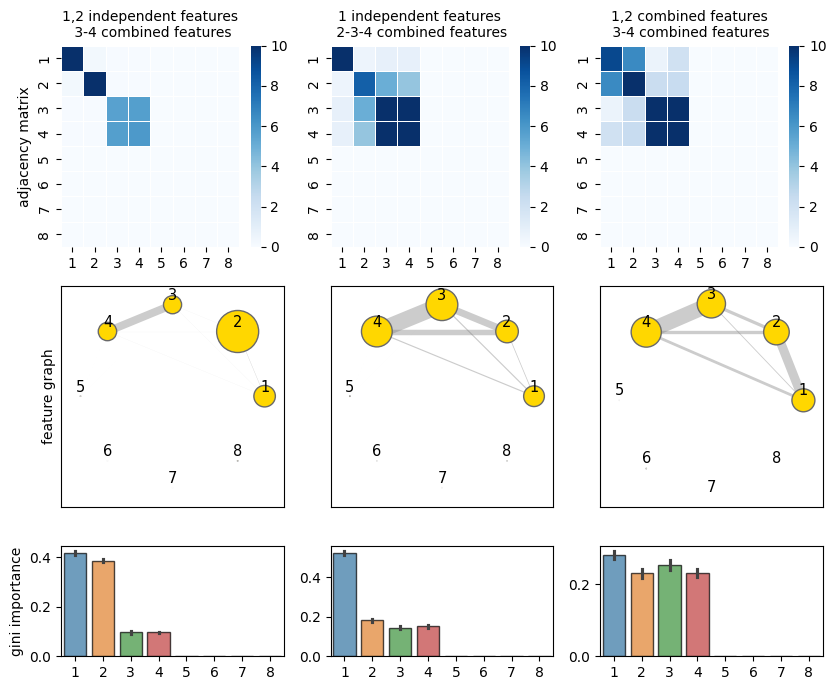

In [139]:
#fig, axes = plt.subplots(5, 4, width_ratios=[2, 1.2, 2, 1.2], figsize=(8.5, 10))
fig, axes = plt.subplots(3, 3, figsize=(8.5, 7), height_ratios=[2, 2.2, 1.1])
feat_names = ["1", "2", "3", "4", "5", "6", "7", "8"]
cmap = "Blues"
sns.heatmap(all_adj2["1-2-34"], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][0], xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj2["1-234"], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][1], xticklabels = feat_names, yticklabels = feat_names) 
sns.heatmap(all_adj2["12-34"], cmap = cmap, vmin = 0, vmax = 10, linewidth=.5, ax = axes[0][2], xticklabels = feat_names, yticklabels = feat_names)

plot_adj_graph(all_adj2["1-2-34"], axes[1][0], feat_names)
plot_adj_graph(all_adj2["1-234"], axes[1][1], feat_names)
plot_adj_graph(all_adj2["12-34"], axes[1][2], feat_names)

sns.barplot(pd.DataFrame(all_imp2["1-2-34"].mean(axis = 2).T, columns = feat_names), ax = axes[2][0], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp2["1-234"].mean(axis = 2).T, columns = feat_names), ax = axes[2][1], edgecolor="k", alpha = 0.7)
sns.barplot(pd.DataFrame(all_imp2["12-34"].mean(axis = 2).T, columns = feat_names), ax = axes[2][2], edgecolor="k", alpha = 0.7)

axes[0][0].set_title("1,2 independent features\n 3-4 combined features", fontsize = 10)
axes[0][1].set_title("1 independent features\n 2-3-4 combined features", fontsize = 10)
axes[0][2].set_title("1,2 combined features\n 3-4 combined features", fontsize = 10)

axes[0][0].set_ylabel("adjacency matrix", fontsize = 10)
axes[1][0].set_ylabel("feature graph", fontsize = 10)
axes[2][0].set_ylabel("gini importance", fontsize = 10)

plt.tight_layout()
#plt.savefig("synthetic2.pdf")
#plt.savefig("synthetic2.png", dpi = 300)